In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bookings=pd.read_csv("hotel_bookings.csv")

In [3]:
df=pd.DataFrame(bookings)

In [6]:
#checking for null values
df.isna().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
is_canceled                            0
market_segment                         0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
babies                                 0
meal                                   0
reservation_status_date                0
distribution_channel                   0
reservation_status                     0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes 

In [7]:
#dropping columns that have null values and are irrelevant to our classification model 
df2=df.drop(['company','agent','country'], axis='columns')

In [8]:
#perform pre-processing on the column 'children', which has some null values, with 0. 
df2['children'].fillna(0,inplace=True)

In [9]:
# perform pre-processing on "meal" contains values "Undefined",
#which is equal to SC (as mentioned in by the contributor of the dataset)
df2["meal"].replace("Undefined", "SC", inplace=True)

In [10]:
#perform pre-processing on bookings that have no hotel guests
zero_guests = list(df2.loc[df2["adults"]
                   + df2["children"]
                   + df2["babies"]==0].index)
df2.drop(df2.index[zero_guests], inplace=True)

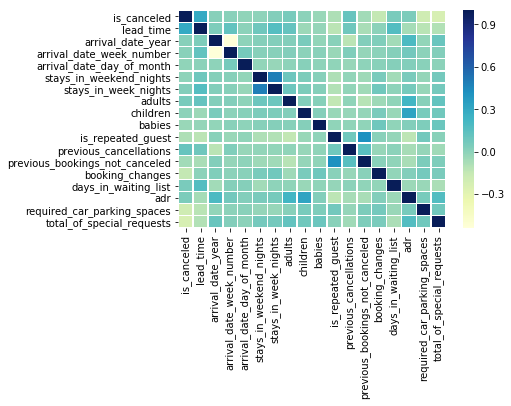

In [11]:
#generating a correlation matrix
sns.heatmap(df2.corr(),  linewidths=.5, cmap="YlGnBu", annot=False)

In [12]:
#generating correlation in respect to our target 'is_canceled'
corr_canceled = df2.corr()["is_canceled"]
corr_canceled.abs().sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004851
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

In [13]:
#dropping unwanted features
df3=df2.drop(['arrival_date_year','arrival_date_day_of_month','reservation_status','stays_in_weekend_nights',
 'reservation_status_date'], axis='columns')
numeric_features = df3.select_dtypes(include=['int64', 'float64']).drop(['is_canceled'], axis=1).columns
categorical_features = df3.select_dtypes(include=['object']).columns


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [15]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [17]:
from sklearn.model_selection import train_test_split
X=df3.drop('is_canceled',axis=1)
y=df3['is_canceled']
train_X,test_X,train_y,test_y=train_test_split(X,y,random_state=0)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [19]:
classifiers = [
    KNeighborsClassifier(5),
     AdaBoostClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(n_estimators=100)
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(train_X, train_y)   
    print(classifier)
    print("model score: %.3f" % pipe.score(test_X,test_y))
    print("/n")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
model score: 0.825
/n
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
model score: 0.815
/n
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fractio

In [20]:
#visualising the feature importance 
#on anaconda prompt: 
#pip install eli5
#conda install -c conda-forge eli5
onehot_columns = list(pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
                      .get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

In [21]:
import eli5
eli5.explain_weights(pipe.named_steps['classifier'], top=25, feature_names=numeric_features_list)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.1772 ± 0.0391,lead_time
0.1226 ± 0.0146,adr
0.0853 ± 0.1717,deposit_type_No Deposit
0.0757 ± 0.0062,arrival_date_week_number
0.0710 ± 0.1657,deposit_type_Non Refund
0.0627 ± 0.0330,total_of_special_requests
0.0595 ± 0.0102,stays_in_week_nights
0.0374 ± 0.0359,previous_cancellations
0.0241 ± 0.0186,booking_changes
0.0217 ± 0.0128,required_car_parking_spaces
